In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from pathlib import Path
import logging
from pathlib import Path
import sys
import matplotlib.dates as mdates
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# Define path
DATA_DIR = PROJECT_ROOT / "data" / "processed"

EVENTS_PROPS_FILE = DATA_DIR / "events_with_properties.csv"
ITEM_PROPS_FILE = DATA_DIR / "item_properties.csv" 
USER_FEATS_FILE = DATA_DIR / "user_features.csv"

### Load data

In [3]:
def load(path):
    logging.info("Loading from %s", path)
    df = pd.read_csv(path)
    if 'timestamp'in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    if 'first_event'in df.columns:
        df['first_event'] = pd.to_datetime(df['first_event'])
    if 'last_event'in df.columns:
        df['last_event'] = pd.to_datetime(df['last_event'])
    return df
events = load(EVENTS_PROPS_FILE)
item_props = load(ITEM_PROPS_FILE)
user_feats = load(USER_FEATS_FILE)

### EDA

#### BASIC EDA EVENTS

In [4]:
df = events.copy()
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.day_name()
df['month'] = df['timestamp'].dt.month

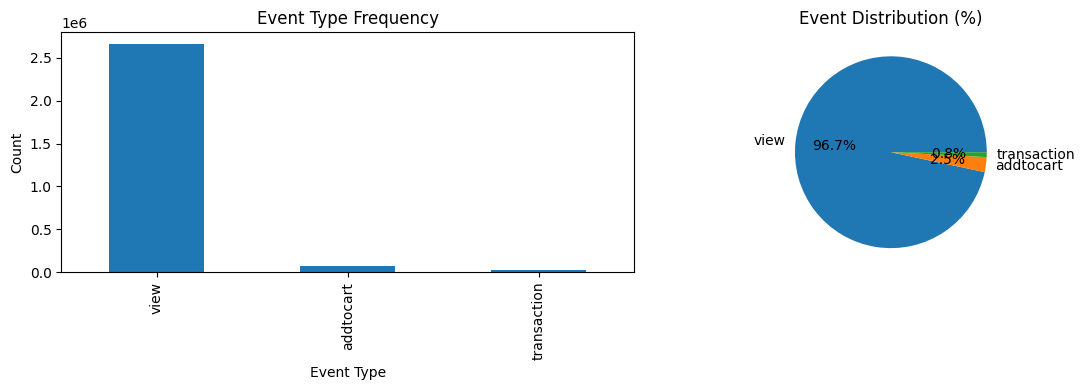

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df['event'].value_counts().plot(
    kind='bar',
    ax=axes[0]
)
axes[0].set_title("Event Type Frequency")
axes[0].set_xlabel("Event Type")
axes[0].set_ylabel("Count")


df['event'].value_counts(normalize=True).plot(
    kind='pie',
    autopct='%1.1f%%',
    ax=axes[1]
)
axes[1].set_title("Event Distribution (%)")
axes[1].set_ylabel("")  

plt.tight_layout()
plt.show()

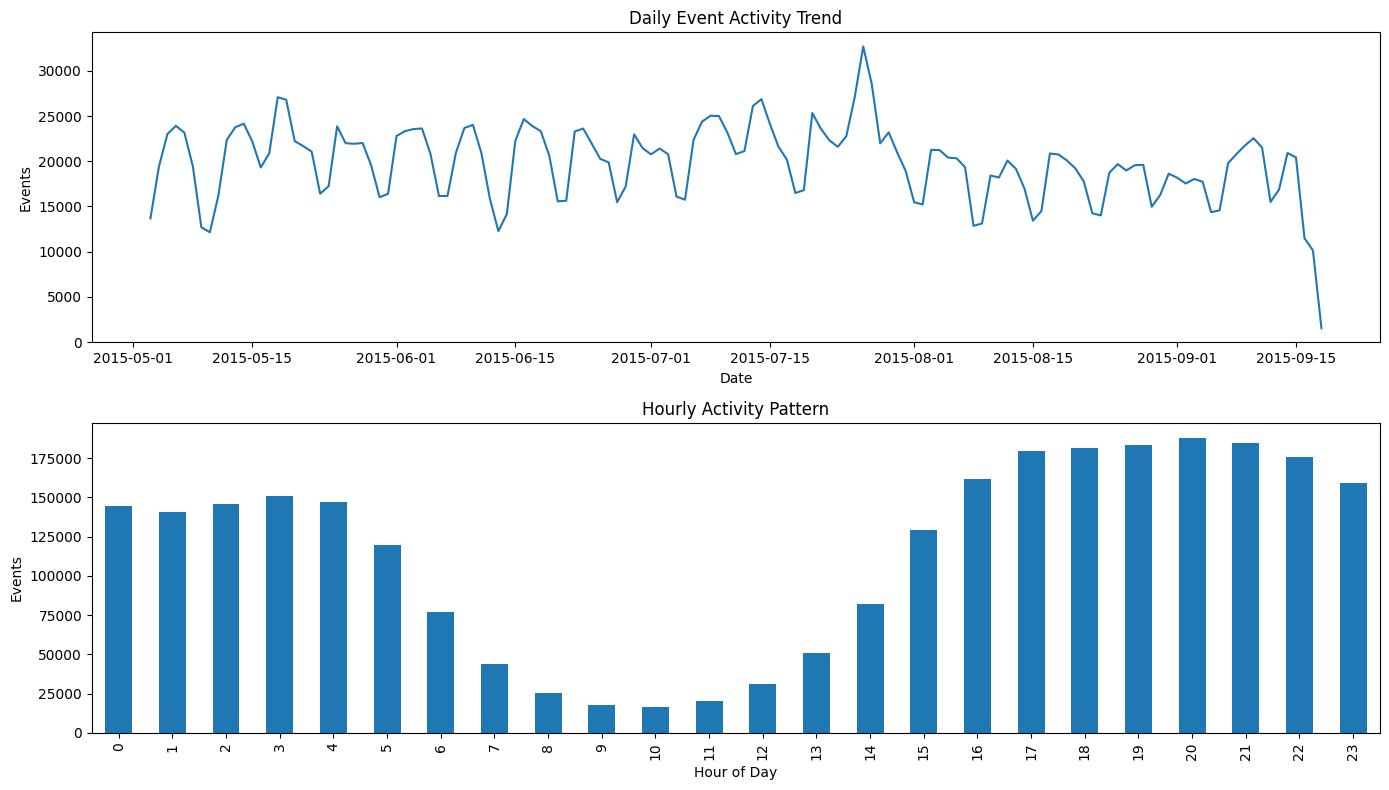

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

daily = df.groupby('date').size()
daily.plot(ax=axes[0])
axes[0].set_title("Daily Event Activity Trend")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Events")

df.groupby('hour').size().plot(
    kind='bar',
    ax=axes[1]
)
axes[1].set_title("Hourly Activity Pattern")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("Events")

plt.tight_layout()
plt.show()


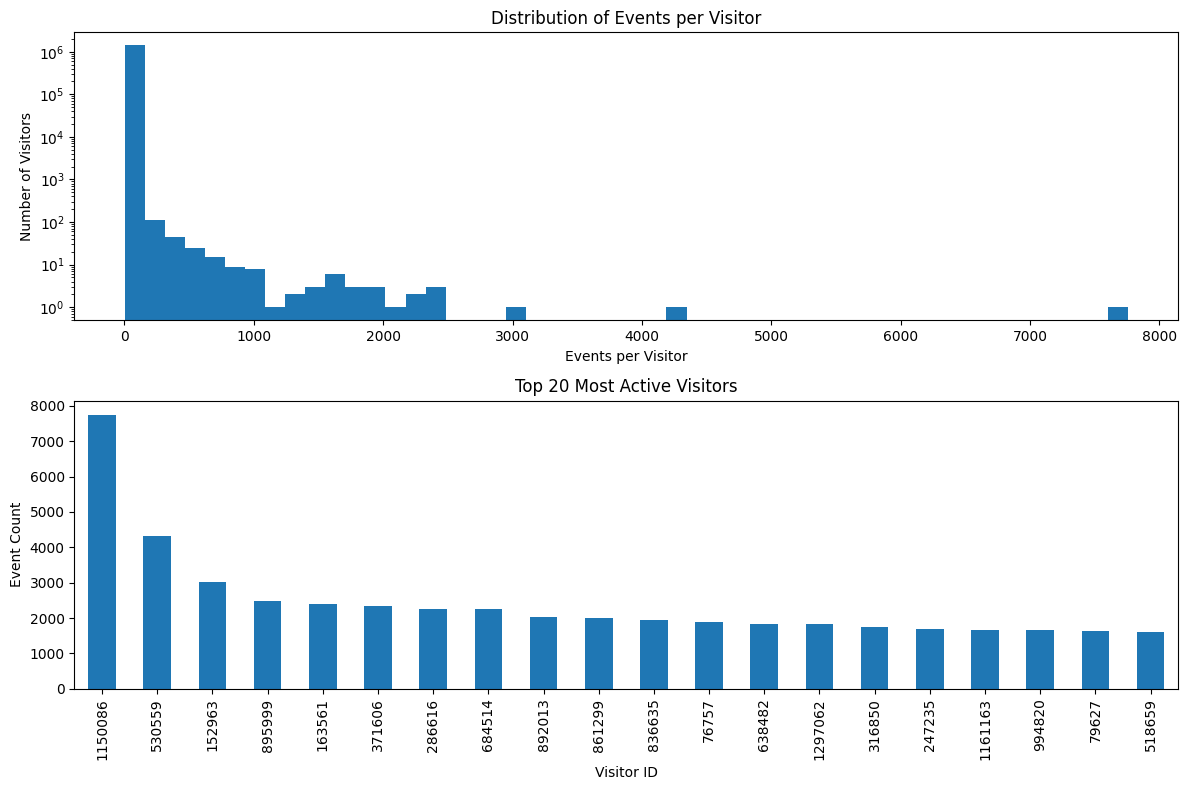

In [7]:
user_events = df.groupby('visitorid').size()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].hist(user_events, bins=50)
axes[0].set_title("Distribution of Events per Visitor")
axes[0].set_xlabel("Events per Visitor")
axes[0].set_ylabel("Number of Visitors")
axes[0].set_yscale("log")

top_users = user_events.sort_values(ascending=False).head(20)
top_users.plot(
    kind='bar',
    ax=axes[1]
)
axes[1].set_title("Top 20 Most Active Visitors")
axes[1].set_ylabel("Event Count")
axes[1].set_xlabel("Visitor ID")

plt.tight_layout()
plt.show()

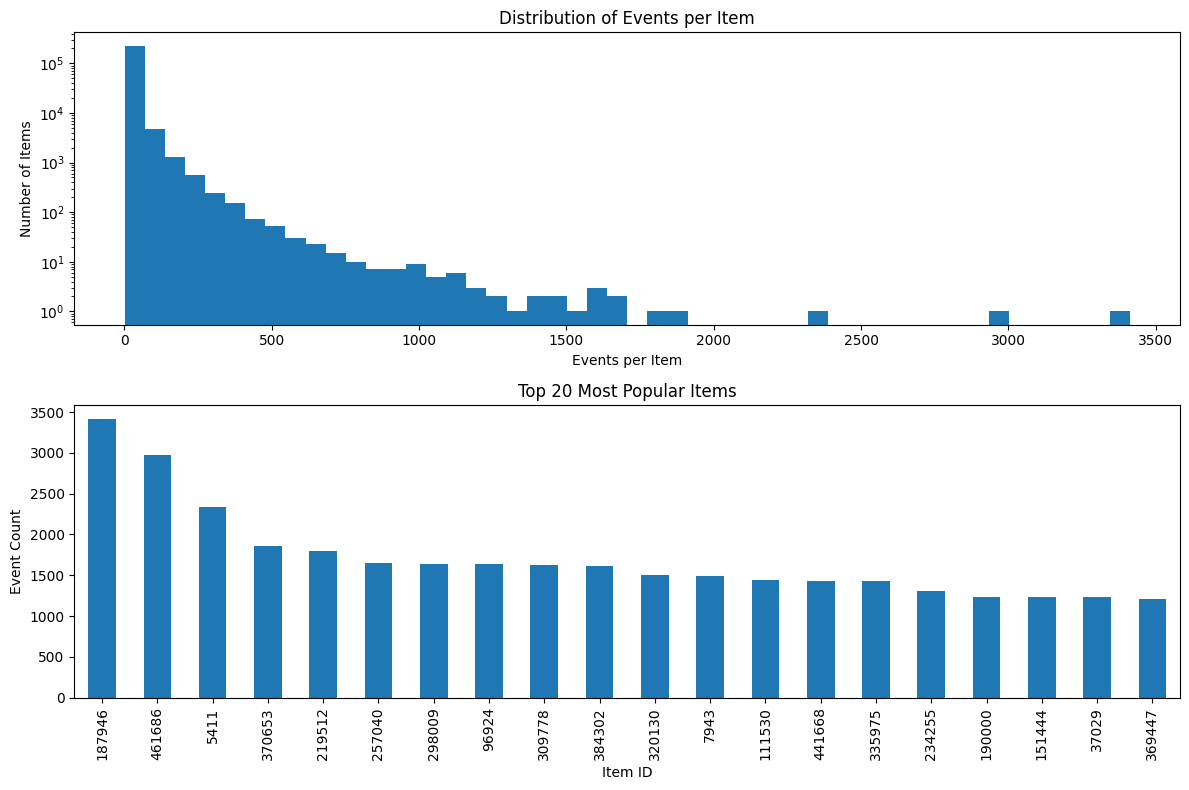

In [8]:
item_counts = df.groupby('itemid').size()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].hist(item_counts, bins=50)
axes[0].set_title("Distribution of Events per Item")
axes[0].set_xlabel("Events per Item")
axes[0].set_ylabel("Number of Items")
axes[0].set_yscale("log")

top_items = item_counts.sort_values(ascending=False).head(20)
top_items.plot(
    kind='bar',
    ax=axes[1]
)
axes[1].set_title("Top 20 Most Popular Items")
axes[1].set_ylabel("Event Count")
axes[1].set_xlabel("Item ID")

plt.tight_layout()
plt.show()

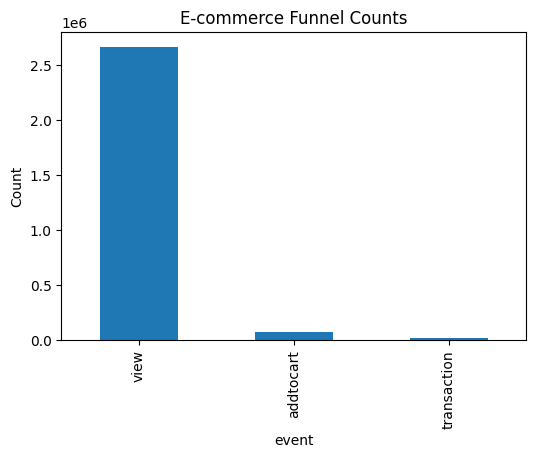

Add-to-cart rate: 0.02602247784793973
Purchase rate: 0.008428817645981402


In [9]:
funnel = df['event'].value_counts()[['view', 'addtocart', 'transaction']]
plt.figure(figsize=(6,4))
funnel.plot(kind='bar')
plt.title("E-commerce Funnel Counts")
plt.ylabel("Count")
plt.show()
# Conversion rate
view_count = funnel['view']
add_to_cart_count = funnel['addtocart']
transaction_count = funnel['transaction']
print("Add-to-cart rate:", add_to_cart_count / view_count)
print("Purchase rate:", transaction_count / view_count)


#### EDA transactions

In [10]:
df_tx = df[df['event'] == 'transaction'].copy()
df_tx_grouped = (
    df_tx.groupby('transactionid')
         .agg(
             visitorid=('visitorid','first'),
             timestamp=('timestamp','min'),
             total_items=('itemid','nunique'),
             total_rows=('itemid','count'),
             total_price=('price','sum'),
             avg_price=('price','mean'),
             min_price=('price','min'),
             max_price=('price','max'),
         )
         .reset_index()
)
df_tx_grouped['date'] = df_tx_grouped['timestamp'].dt.date
df_tx_grouped['hour'] = df_tx_grouped['timestamp'].dt.hour
df_tx_grouped['dayofweek'] = df_tx_grouped['timestamp'].dt.day_name()
df_tx_grouped.head()


,transactionid,visitorid,timestamp,total_items,total_rows,total_price,avg_price,min_price,max_price,date,hour,dayofweek
0,0.0,90352,2015-06-15 21:36:37.081,1,1,47400.0,47400.0,47400.0,47400.0,2015-06-15,21,Monday
1,1.0,1150086,2015-07-14 18:30:08.851,1,1,390480.0,390480.0,390480.0,390480.0,2015-07-14,18,Tuesday
2,2.0,556967,2015-06-03 18:02:29.857,1,1,64080.0,64080.0,64080.0,64080.0,2015-06-03,18,Wednesday
3,3.0,424452,2015-06-22 00:12:41.626,1,1,0.0,NaN,NaN,NaN,2015-06-22,0,Monday
4,4.0,531661,2015-06-07 22:40:24.966,1,1,85680.0,85680.0,85680.0,85680.0,2015-06-07,22,Sunday


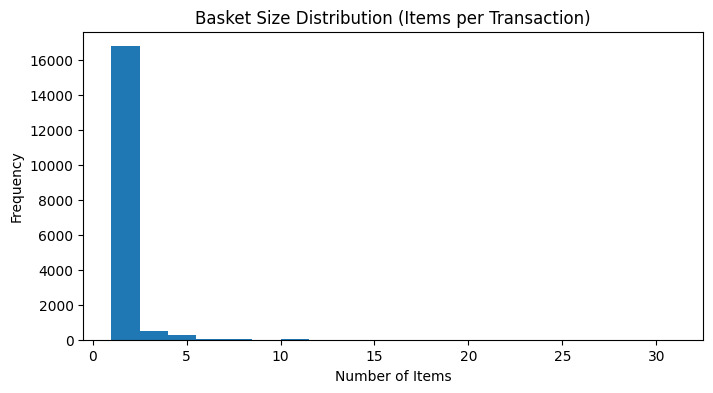

In [11]:
plt.figure(figsize=(8,4))
plt.hist(df_tx_grouped['total_items'], bins=20)
plt.title("Basket Size Distribution (Items per Transaction)")
plt.xlabel("Number of Items")
plt.ylabel("Frequency")
plt.show()



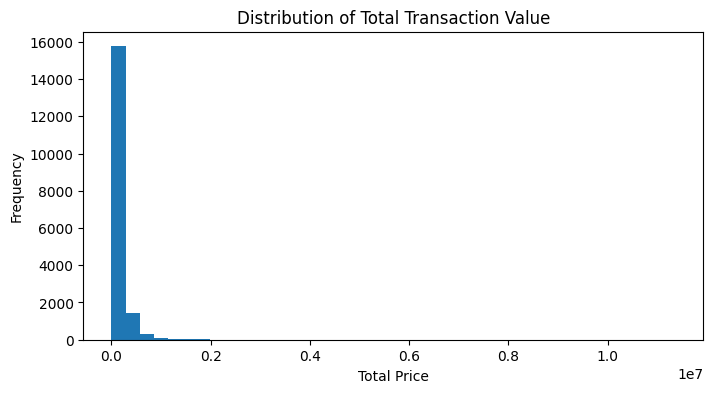

In [12]:
plt.figure(figsize=(8,4))
plt.hist(df_tx_grouped['total_price'], bins=40)
plt.title("Distribution of Total Transaction Value")
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.show()



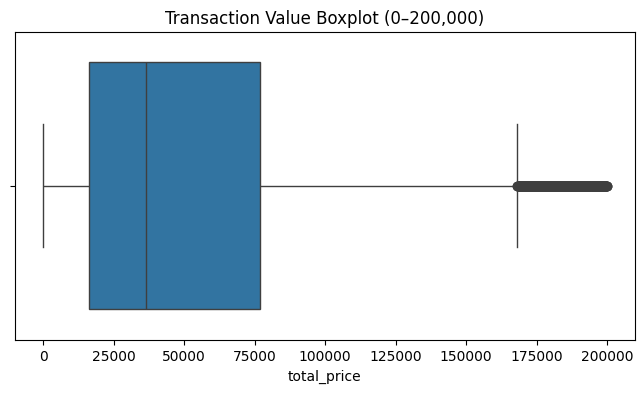

In [13]:
filtered = df_tx_grouped[df_tx_grouped['total_price'] <= 2e5]

plt.figure(figsize=(8,4))
sns.boxplot(x=filtered['total_price'])
plt.title("Transaction Value Boxplot (0–200,000)")
plt.show()


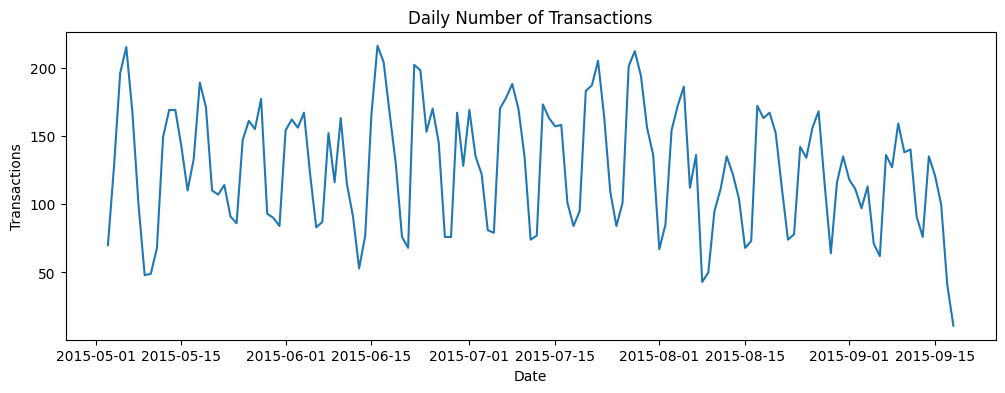

In [14]:
plt.figure(figsize=(12,4))
df_tx_grouped.groupby('date').size().plot()
plt.title("Daily Number of Transactions")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.show()


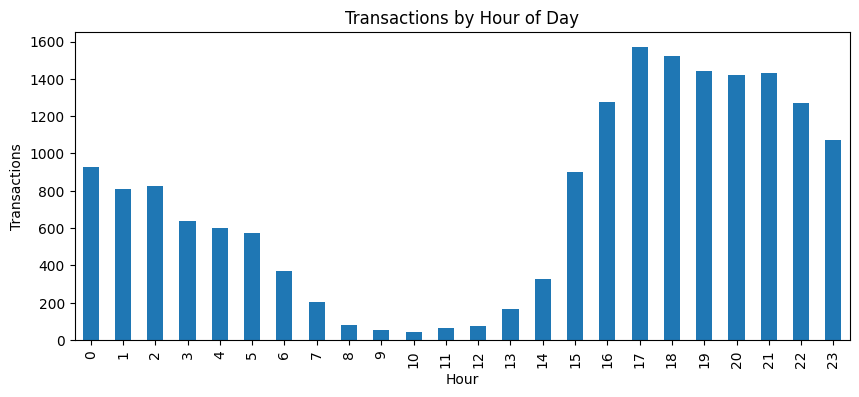

In [15]:
plt.figure(figsize=(10,4))
df_tx_grouped['hour'].value_counts().sort_index().plot(kind='bar')
plt.title("Transactions by Hour of Day")
plt.ylabel("Transactions")
plt.xlabel("Hour")
plt.show()


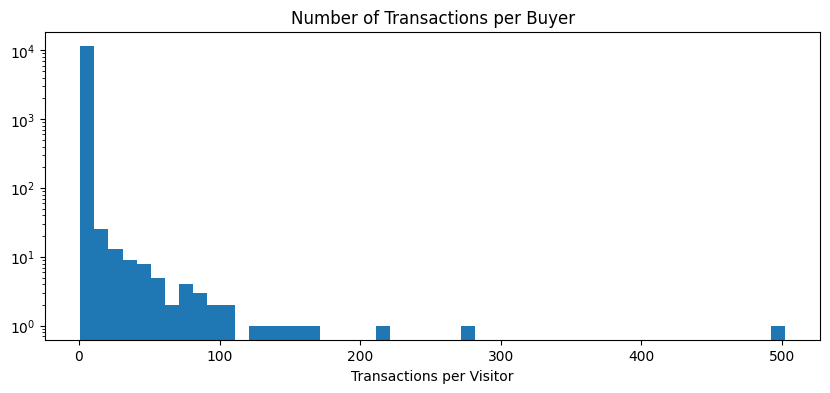

In [16]:
buyer_tx_count = df_tx_grouped['visitorid'].value_counts()

plt.figure(figsize=(10,4))
plt.hist(buyer_tx_count, bins=50)
plt.title("Number of Transactions per Buyer")
plt.xlabel("Transactions per Visitor")
plt.yscale('log')
plt.show()


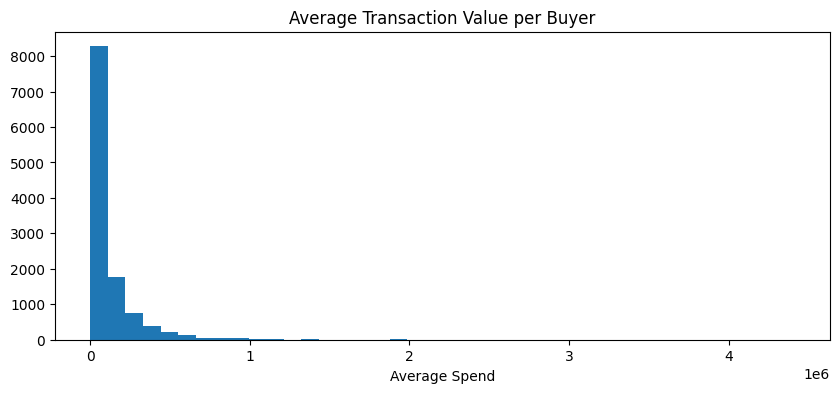

In [17]:
buyer_avg_spend = df_tx_grouped.groupby('visitorid')['total_price'].mean()

plt.figure(figsize=(10,4))
plt.hist(buyer_avg_spend, bins=40)
plt.title("Average Transaction Value per Buyer")
plt.xlabel("Average Spend")
plt.show()


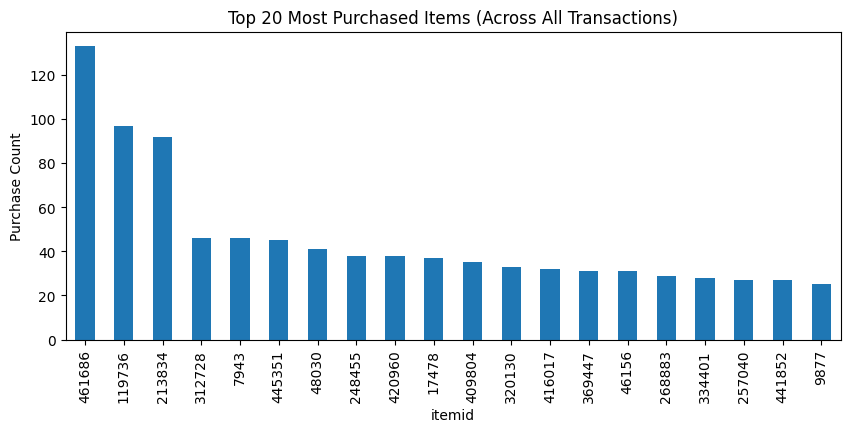

In [18]:
item_freq = df_tx['itemid'].value_counts().head(20)

plt.figure(figsize=(10,4))
item_freq.plot(kind='bar')
plt.title("Top 20 Most Purchased Items (Across All Transactions)")
plt.ylabel("Purchase Count")
plt.show()


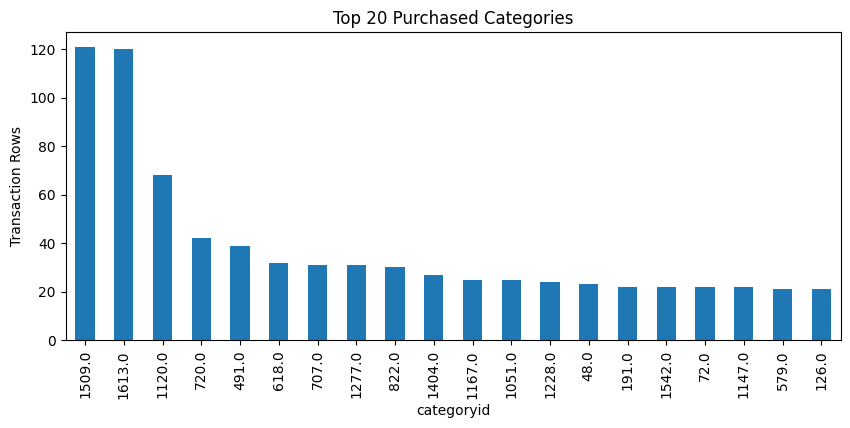

In [19]:
category_counts = df_tx.groupby('categoryid').size().sort_values(ascending=False).head(20)

plt.figure(figsize=(10,4))
category_counts.plot(kind='bar')
plt.title("Top 20 Purchased Categories")
plt.ylabel("Transaction Rows")
plt.show()

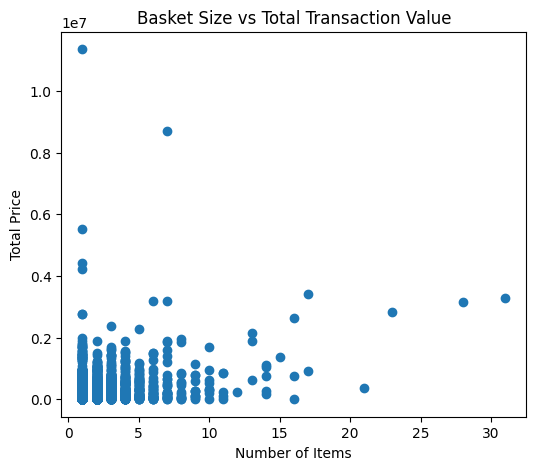

In [20]:
plt.figure(figsize=(6,5))
plt.scatter(df_tx_grouped['total_items'], df_tx_grouped['total_price'])
plt.title("Basket Size vs Total Transaction Value")
plt.xlabel("Number of Items")
plt.ylabel("Total Price")
plt.show()


#### EDA FOR REPORT

In [21]:
from matplotlib.ticker import FuncFormatter

daily_tx = df_tx_grouped.groupby('date').agg(
    tx_count=('transactionid','count'),
    avg_tx_value=('total_price','mean'),
    median_tx_value=('total_price','median')
).sort_index()
hourly_tx = df_tx_grouped['hour'].value_counts().sort_index()
funnel_overall = df['event'].value_counts().reindex(['view','addtocart','transaction']).fillna(0)
top_items = df_tx['itemid'].value_counts().head(15)
top_cats = df_tx['categoryid'].value_counts().head(12) if 'categoryid' in df_tx.columns else pd.Series()
buyer_stats = df_tx_grouped.groupby('visitorid')['total_price'].agg(['count','sum','mean']).rename(columns={'count':'num_tx','sum':'total_spend','mean':'avg_tx_value'})
top_buyers = buyer_stats.sort_values('total_spend', ascending=False).head(10)

def money(x, pos):
    if x >= 1e9: return f'{x/1e9:1.2f}B'
    if x >= 1e6: return f'{x/1e6:1.1f}M'
    if x >= 1e3: return f'{x/1e3:1.0f}k'
    return f'{int(x)}'

money_formatter = FuncFormatter(money)



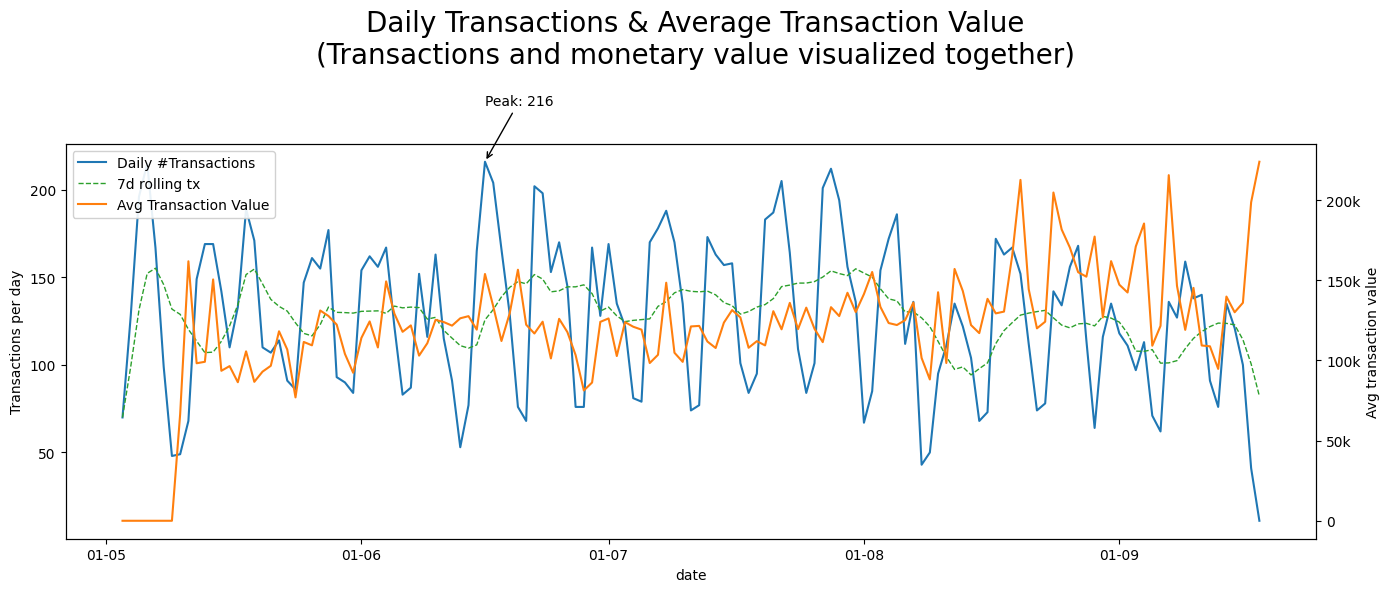

In [22]:
plt.figure(figsize=(14,6))
ax = plt.gca()

daily_tx['tx_count'].plot(ax=ax, label='Daily #Transactions', linewidth=1.5)
ax.set_ylabel('Transactions per day')
ax.set_xlabel('Date')

ax2 = ax.twinx()
daily_tx['avg_tx_value'].plot(ax=ax2, color='tab:orange', label='Avg Transaction Value', linewidth=1.5)
ax2.set_ylabel('Avg transaction value')
ax2.yaxis.set_major_formatter(money_formatter)

rolling = daily_tx['tx_count'].rolling(7, min_periods=1).mean()
rolling.plot(ax=ax, color='tab:green', linestyle='--', linewidth=1, label='7d rolling tx')
max_day = daily_tx['tx_count'].idxmax()
max_val = daily_tx['tx_count'].max()
ax.annotate(f'Peak: {max_val}', xy=(max_day, max_val), xytext=(max_day, max_val*1.15),
            arrowprops=dict(arrowstyle='->', color='black'))
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left', framealpha=0.9)



ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))   
fig = plt.gcf()
fig.suptitle(
    "Daily Transactions & Average Transaction Value\n(Transactions and monetary value visualized together)",
    fontsize=20,
    y=0.98  
)


plt.subplots_adjust(top=0.88)
plt.tight_layout()
#plt.savefig('figure1_daily_tx_value.png', dpi=200)
plt.show()



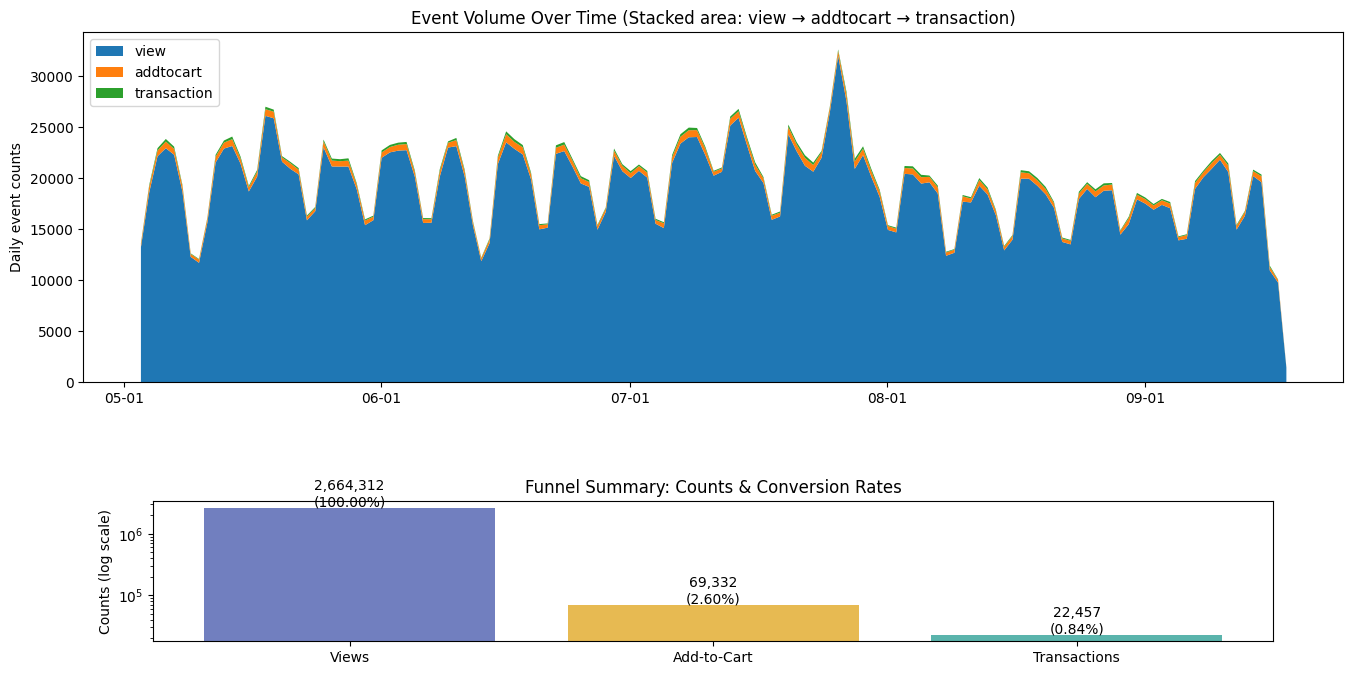

In [23]:
daily_events = df.groupby('date')['event'].value_counts().unstack(fill_value=0).reindex(index=daily_tx.index, fill_value=0)



fig = plt.figure(figsize=(14,7))
ax1 = fig.add_axes([0.05,0.44,0.9,0.50])  
daily_events[['view','addtocart','transaction']].plot.area(ax=ax1, stacked=True, linewidth=0)

ax1.set_title('Event Volume Over Time (Stacked area: view → addtocart → transaction)')
ax1.set_ylabel('Daily event counts')
ax1.set_xlabel('')
ax1.legend(loc='upper left')

ax2 = fig.add_axes([0.1,0.07,0.8,0.20])
events_total = funnel_overall
vals = [events_total.get('view',0), events_total.get('addtocart',0), events_total.get('transaction',0)]
labels = ['Views','Add-to-Cart','Transactions']
xpos = np.arange(len(vals))
bars = ax2.bar(xpos, vals, color=["#717fbf",'#e7ba52','#5ab4ac'])
ax2.set_xticks(xpos)
ax2.set_xticklabels(labels)
ax2.set_yscale('log')  # use log scale if large differences exist (visually clearer)
ax2.set_ylabel('Counts (log scale)')
for r, v in enumerate(vals):
    ax2.text(r, v*1.05, f'{v:,}\n({(v/vals[0]*100 if vals[0]>0 else 0):.2f}%)', ha='center')

ax2.set_title('Funnel Summary: Counts & Conversion Rates')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

#plt.savefig('funnel_events.png', dpi=200)
plt.show()


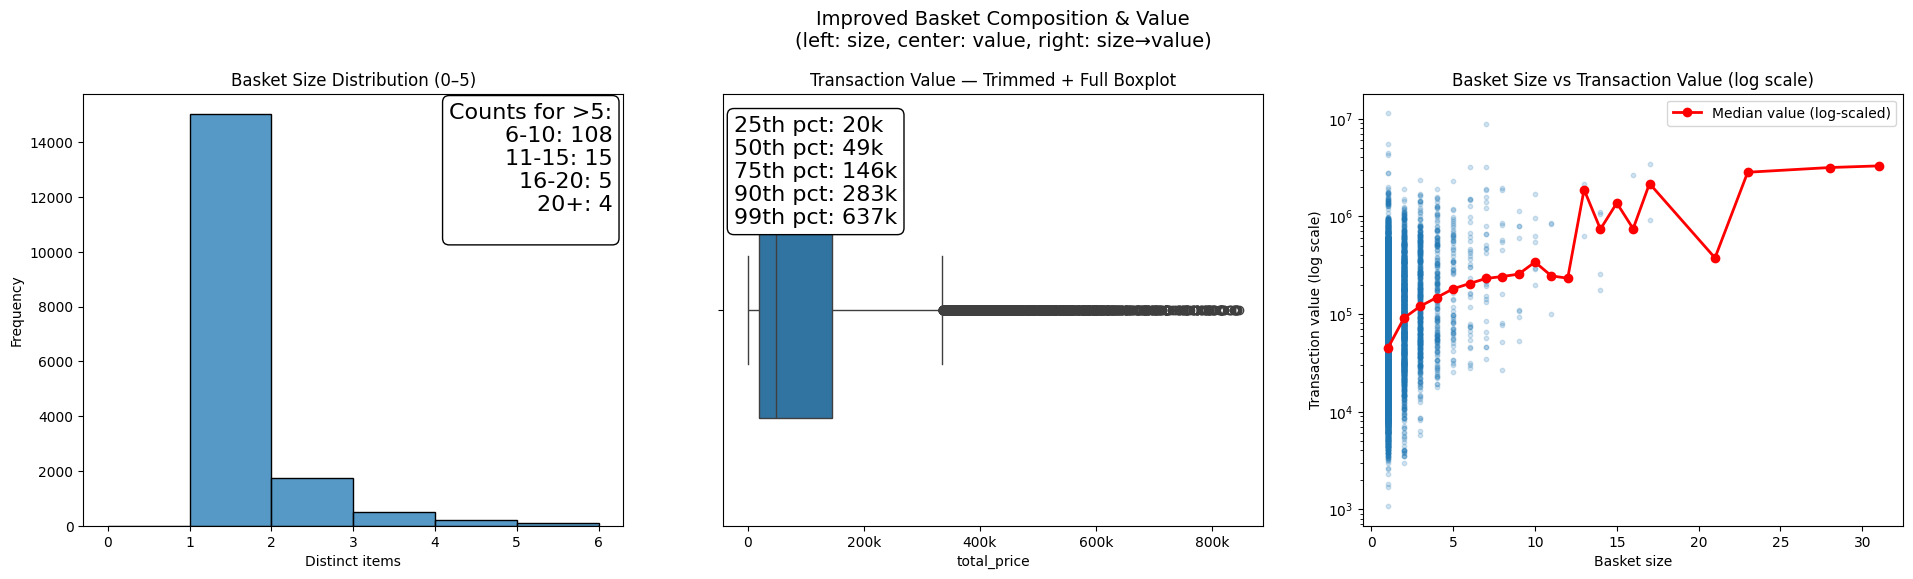

In [24]:
fig = plt.figure(figsize=(20,6))

ax1 = fig.add_axes([0.04, 0.18, 0.27, 0.72])
ax2 = fig.add_axes([0.36, 0.18, 0.27, 0.72])
ax3 = fig.add_axes([0.68, 0.18, 0.27, 0.72])

df_sizes = df_tx_grouped['total_items']

sns.histplot(
    df_sizes[df_sizes <= 5],
    bins=range(0,7),
    ax=ax1
)
ax1.set_title("Basket Size Distribution (0–5)")
ax1.set_xlabel("Distinct items")
ax1.set_ylabel("Frequency")

bins = [(6,10), (11,15), (16,20)]
table_data = []

for lo, hi in bins:
    count = ((df_sizes >= lo) & (df_sizes <= hi)).sum()
    table_data.append((f"{lo}-{hi}", count))
count_over20 = (df_sizes > 20).sum()
table_data.append(("20+", count_over20))

text_table = "Counts for >5:\n"
for label, val in table_data:
    text_table += f"{label}: {val}\n"

ax1.text(
    0.98, 0.98,
    text_table,
    transform=ax1.transAxes,
    va='top',
    ha='right',
    fontsize=16,
    bbox=dict(boxstyle="round", fc="white", ec="black")
)

prices = df_tx_grouped['total_price']

# trimmed version (<= P99)
p99 = prices.quantile(0.99)
trimmed = prices[prices <= p99]
sns.boxplot(
    x=trimmed,
    ax=ax2,
    width=0.5
)

ax2.set_title("Transaction Value — Trimmed + Full Boxplot")
ax2.xaxis.set_major_formatter(money_formatter)

pcts = trimmed.quantile([0.25,0.5,0.75,0.9,0.99]).to_dict()
pct_text = '\n'.join([f'{int(k*100)}th pct: {money(v,0)}' for k,v in pcts.items()])

ax2.text(
    0.02, 0.95, pct_text,
    transform=ax2.transAxes,
    va='top',
    fontsize=16,
    bbox=dict(boxstyle="round", fc="white", ec="black")
)

ax3.scatter(
    df_tx_grouped['total_items'],
    prices,
    alpha=0.2,
    s=10
)

ax3.set_yscale('log')    
ax3.set_title("Basket Size vs Transaction Value (log scale)")
ax3.set_xlabel("Basket size")
ax3.set_ylabel("Transaction value (log scale)")
median_by_size = df_tx_grouped.groupby('total_items')['total_price'].median()
ax3.plot(
    median_by_size.index,
    median_by_size.values,
    color='red',
    marker='o',
    linewidth=2,
    label='Median value (log-scaled)'
)
ax3.legend()
fig.suptitle(
    "Improved Basket Composition & Value\n(left: size, center: value, right: size→value)",
    y=1.04,
    fontsize=14
)
plt.show()


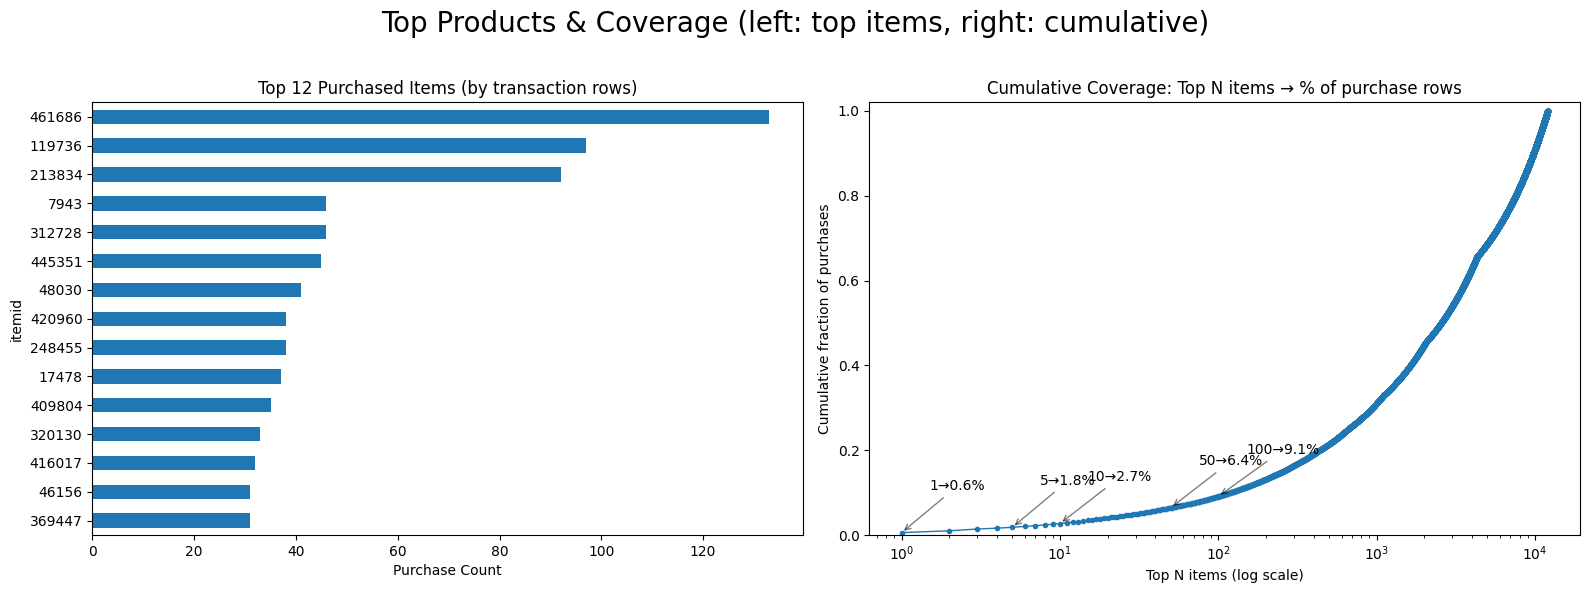

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,6))

if len(top_items) > 0:
    top_items.sort_values().plot(kind='barh', ax=axes[0])
    axes[0].set_title('Top 12 Purchased Items')
    axes[0].set_xlabel('Purchase Count')
else:
    axes[0].text(0.5,0.5,"No item data", ha='center')
item_counts_full = df_tx['itemid'].value_counts().sort_values(ascending=False)
cumulative = item_counts_full.cumsum() / item_counts_full.sum()
axes[1].plot(np.arange(1, len(cumulative)+1), cumulative.values, marker='.', linewidth=1)
axes[1].set_xscale('log')
axes[1].set_ylim(0,1.02)
axes[1].set_title('Cumulative Coverage: Top N items → % of purchase rows')
axes[1].set_xlabel('Top N items (log scale)')
axes[1].set_ylabel('Cumulative fraction of purchases')
for n in [1,5,10,50,100]:
    if n <= len(cumulative):
        y = cumulative.iloc[n-1]
        axes[1].annotate(
            f'{n}→{y*100:.1f}%',
            xy=(n, y),
            xytext=(n*1.5, min(1.0, y + 0.10)),   # more separation
            arrowprops=dict(arrowstyle='->', alpha=0.5),
            fontsize=10
        )
fig.suptitle('Top Products & Coverage (left: top items, right: cumulative)', fontsize = 20)
plt.tight_layout(rect=[0,0,1,0.96])
#plt.savefig('figure4_top_items_coverage.png', dpi=200)
plt.show()





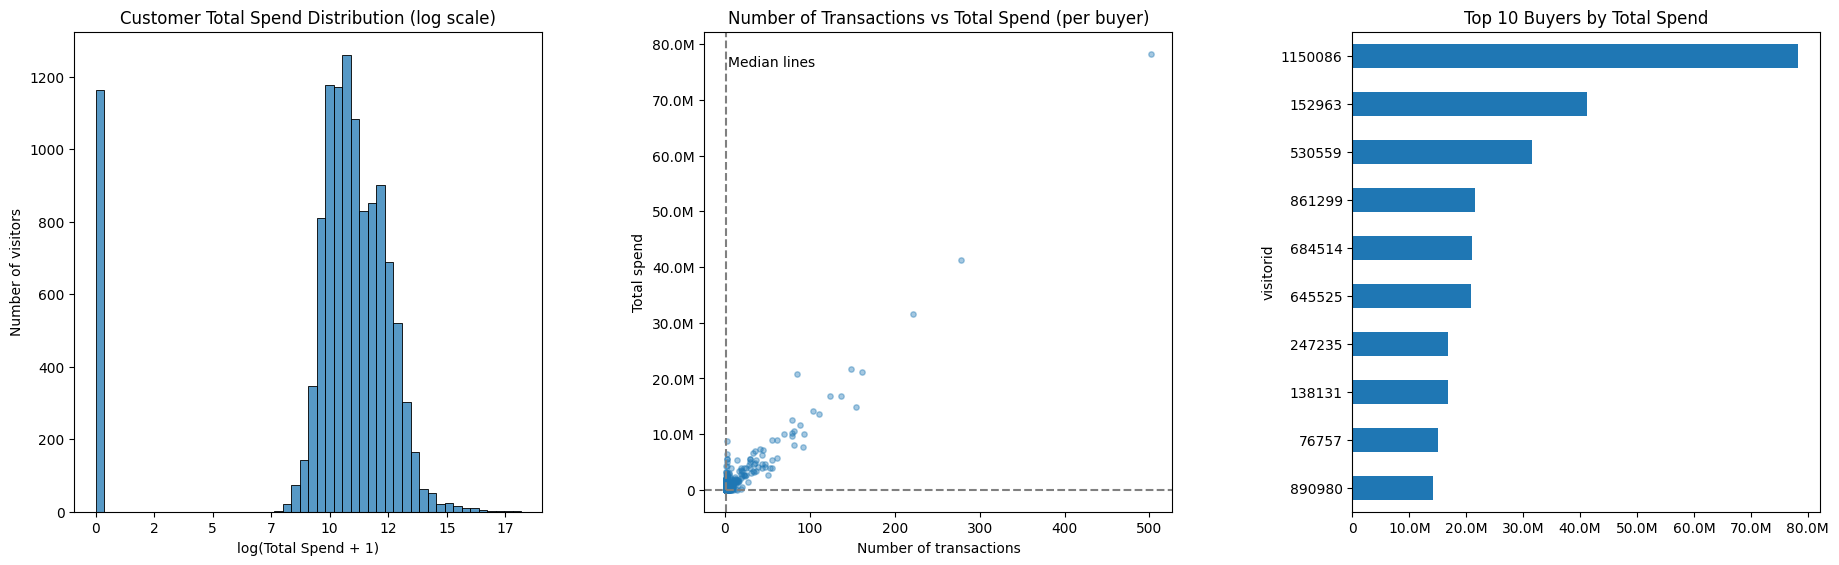

In [26]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_axes([0.03, 0.1, 0.26, 0.8])  
ax2 = fig.add_axes([0.38, 0.1, 0.26, 0.8])  
ax3 = fig.add_axes([0.74, 0.1, 0.26, 0.8])   

sns.histplot(np.log1p(buyer_stats['total_spend']), bins=50, ax=ax1)
ax1.set_title('Customer Total Spend Distribution (log scale)')
ax1.set_xlabel('log(Total Spend + 1)')
ax1.set_ylabel('Number of visitors')
ax1.xaxis.set_major_formatter(money_formatter)


ax2.scatter(buyer_stats['num_tx'], buyer_stats['total_spend'], alpha=0.4, s=15)
ax2.set_title('Number of Transactions vs Total Spend (per buyer)')
ax2.set_xlabel('Number of transactions')
ax2.set_ylabel('Total spend')
ax2.yaxis.set_major_formatter(money_formatter)

ax2.axvline(buyer_stats['num_tx'].median(), linestyle='--', color='grey')
ax2.axhline(buyer_stats['total_spend'].median(), linestyle='--', color='grey')
ax2.text(0.05,0.95, 'Median lines', transform=ax2.transAxes, va='top')

top_buyers['total_spend'].sort_values().plot(kind='barh', ax=ax3) 
ax3.set_title('Top 10 Buyers by Total Spend') 
ax3.xaxis.set_major_formatter(money_formatter)

plt.subplots_adjust(top=0.99)
#plt.savefig('figure5_buyer_value.png', dpi=200)
plt.show()
